In [23]:
import cv2
import random
from matplotlib import pyplot 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import scipy
import seaborn as sns
import os
from skimage import io
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1, MobileNet,MobileNetV2,NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from keras.losses import binary_crossentropy 
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K
from keras.losses import binary_crossentropy
np.random.seed(13)

In [24]:
brain_df = pd.read_csv('brain_mri_data.csv')
brain_df_train = brain_df.drop(columns=['Unnamed:0', 'patient_id'], axis=1, errors='ignore')
brain_df_train['diagnosis'] = brain_df['diagnosis'].apply(lambda x: str(x)) #changes the type of the values of the column to sting
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   diagnosis   3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [25]:
brain_df_mask = brain_df_train[brain_df_train['diagnosis'] == '1']
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)
print(f"Train size: {len(X_train)} images, Validation size: {len(X_val)} images, Test size: {len(X_test)} images")


Train size is 1167, valid size is 103 & test size is 103
Train size: 1167 images, Validation size: 103 images, Test size: 103 images


In [26]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 224, img_w = 224, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_dataset = DataGenerator(train_ids, train_mask)
val_dataset = DataGenerator(val_ids, val_mask)

In [27]:

def res_block(input_tensor, filters, kernel_size=3, stride=1):
    # Shortcut (identity) connection
    shortcut = Conv2D(filters, kernel_size=(1,1), strides=stride, padding='same', kernel_initializer='he_normal')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    # Main path: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm
    X = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(input_tensor)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)

    # Add shortcut to the main path
    output_tensor = Add()([X, shortcut])
    output_tensor = Activation('relu')(output_tensor)

    return output_tensor


def upsamp_concate(upsample_input, skip_connection, size=(2, 2)):
    upsampled = UpSampling2D(size=size)(upsample_input)
    output_tensor = Concatenate()([upsampled, skip_connection])
    
    return output_tensor


In [28]:
input_shape = (224,224,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(14, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(14, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = res_block(pool_1, 28)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = res_block(pool_2, 56)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = res_block(pool_3, 112)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = res_block(pool_4, 224)

# Upsample Stage 1
up_1 = upsamp_concate(conv_5, conv_4)
up_1 = res_block(up_1, 112)

# Upsample Stage 2
up_2 = upsamp_concate(up_1, conv_3)
up_2 = res_block(up_2, 56)

# Upsample Stage 3
up_3 = upsamp_concate(up_2, conv_2)
up_3 = res_block(up_3, 28)

# Upsample Stage 4
up_4 = upsamp_concate(up_3, conv_1)
up_4 = res_block(up_4, 14)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 224, 224, 14) 392         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 224, 224, 14) 56          conv2d_77[0][0]                  
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 224, 224, 14) 1778        batch_normalization_76[0][0]     
_______________________________________________________________________________________

Training of the segmentation model

In [29]:
# Defining a custom loss function for UNet model
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred, alpha=0.7):
    """Compute the Tversky index."""
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    
    true_pos = K.sum(y_true_flat * y_pred_flat)
    false_neg = K.sum(y_true_flat * (1 - y_pred_flat))
    false_pos = K.sum((1 - y_true_flat) * y_pred_flat)
    
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    """Compute the Focal Tversky loss."""
    return K.pow((1 - tversky_index(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32))), gamma)

def tversky_loss(y_true, y_pred):
    """Compute the Tversky loss."""
    return 1 - tversky_index(y_true, y_pred)





In [30]:
# Compile the model with Adam optimizer and binary crossentropy loss
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)

seg_model.compile(optimizer= adam_optimizer, 
                  loss=binary_crossentropy, 
                  metrics=['accuracy'])

# Early stopping callback
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=20)

# Save the best model weights
checkpointer = ModelCheckpoint(filepath="ResUNet_segmodel_weights.hdf5", 
                               verbose=1, 
                               save_best_only=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                               mode='min', 
                               verbose=1, 
                               patience=10, 
                               min_delta=0.0001, 
                               factor=0.2)

# Fit the model
history = seg_model.fit(train_dataset, 
                        epochs=10, 
                        validation_data=val_dataset, 
                        callbacks=[checkpointer, earlystopping, reduce_lr])

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9700
Epoch 00001: val_loss improved from inf to 0.11366, saving model to ResUNet_segmodel_weights.hdf5
72/72 [==============================] - 312s 4s/step - loss: 0.1403 - accuracy: 0.9700 - val_loss: 0.1137 - val_accuracy: 0.9697
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9779
Epoch 00002: val_loss improved from 0.11366 to 0.07676, saving model to ResUNet_segmodel_weights.hdf5
72/72 [==============================] - 385s 5s/step - loss: 0.0683 - accuracy: 0.9779 - val_loss: 0.0768 - val_accuracy: 0.9750
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9812   
Epoch 00003: val_loss improved from 0.07676 to 0.05960, saving model to ResUNet_segmodel_weights.hdf5
72/72 [==============================] - 70027s 973s/step - loss: 0.0555 - accuracy: 0.9812 - val_loss: 0.0596 - val_accuracy: 0.9784
Epoch 4/10
72/72 [=

In [31]:
# saving model achitecture in json file
seg_model_json = seg_model.to_json()
with open("UNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)
seg_model.save('segModel')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: segModel\assets


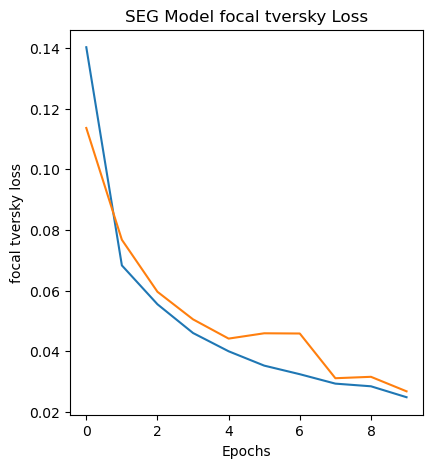

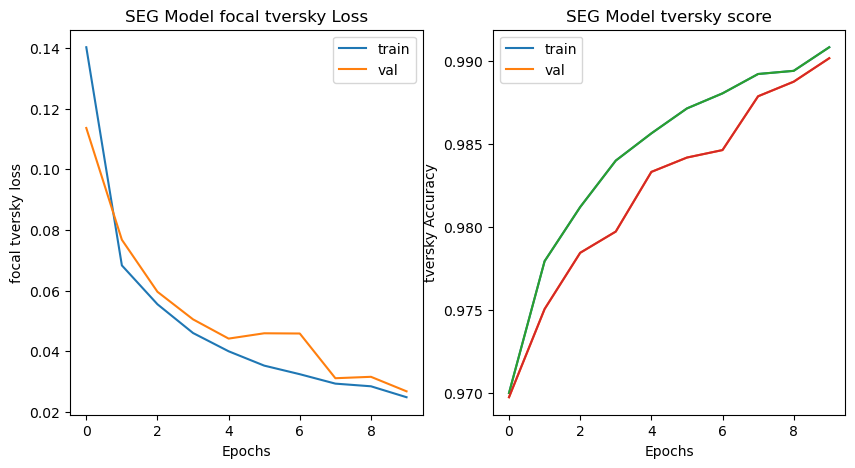

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [34]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 4s 590ms/step - loss: 0.0266 - accuracy: 0.9900
Segmentation tversky is 99.00%


In [65]:
def prediction(test, model, model_seg):
    '''
   Prediction function that takes a dataframe containing image paths as input and performs two types of predictions:
    1. Classification to predict whether the image has a defect or not.
    2. If the model is not 99% confident of no defect, the image is passed to a segmentation network to detect the type and location of the defect.
    
    Parameters:
    test: DataFrame containing a column 'image_path' with paths to images.
    model: List of trained classification models for ensemble voting.
    model_seg: Trained segmentation model.
    
    Returns:
    DataFrame containing image paths, predicted masks, and binary indication of mask presence.
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (224,224))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,224,224,3
        img = np.reshape(img, (1,224,224,3))
        
        #making prediction for tumor in image
        labels = []
        for m in TrainedModel:
            predicts = np.argmax(m.predict(img), axis=1)
            labels.append(predicts)
        is_defect = scipy.stats.mode(labels,axis=0)
        #is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,224,224,1
        X = np.empty((1,224,224,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (224,224))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 224,224,3 to 1,224,224,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [66]:
NasNet = tf.keras.models.load_model('firstModel')
EfficientNet = tf.keras.models.load_model('secondModel')
MobileNetV2 = tf.keras.models.load_model('thirdModel')
TrainedModel = [NasNet,EfficientNet, MobileNetV2,] 

In [67]:
_, test = train_test_split(brain_df_train, test_size=0.15)

In [68]:
df_pred = prediction(test, TrainedModel, seg_model)
df_pred

C:\Users\aisha\AppData\Local\Temp\ipykernel_4584\935206983.py:29: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  is_defect = scipy.stats.mode(labels,axis=0)


image_path  \
0    C:/Users/aisha/machine learning/lgg-mri-segmen...   
1    C:/Users/aisha/machine learning/lgg-mri-segmen...   
2    C:/Users/aisha/machine learning/lgg-mri-segmen...   
3    C:/Users/aisha/machine learning/lgg-mri-segmen...   
4    C:/Users/aisha/machine learning/lgg-mri-segmen...   
..                                                 ...   
585  C:/Users/aisha/machine learning/lgg-mri-segmen...   
586  C:/Users/aisha/machine learning/lgg-mri-segmen...   
587  C:/Users/aisha/machine learning/lgg-mri-segmen...   
588  C:/Users/aisha/machine learning/lgg-mri-segmen...   
589  C:/Users/aisha/machine learning/lgg-mri-segmen...   

                                        predicted_mask  has_mask  
0    [[[[0.00020537], [0.00020441], [0.00046384], [...         1  
1    [[[[0.00113779], [0.00084594], [0.00075474], [...         1  
2    [[[[0.00251529], [0.00302762], [0.00210619], [...         1  
3                                           No mask :)         0  
4    [[[[0.00018007], [0.00018531], [0.00041053], [...         1  
..                                                 ...       ...  
585  [[[[0.00046825], [0.00053984], [0.00057611], [...         1  
586  [[[[0.00126746], [0.00116807], [0.00101084], [...         1  
587  [[[[0.00130689], [0.0010041], [0.00090927], [0...         1  
588  [[[[0.00103161], [0.00064301], [0.00049356], [...         1  
589                                         No mask :)         0  

[590 rows x 3 columns]

In [69]:
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

image_path  \
0  C:/Users/aisha/machine learning/lgg-mri-segmen...   
1  C:/Users/aisha/machine learning/lgg-mri-segmen...   
2  C:/Users/aisha/machine learning/lgg-mri-segmen...   
3  C:/Users/aisha/machine learning/lgg-mri-segmen...   
4  C:/Users/aisha/machine learning/lgg-mri-segmen...   
5  C:/Users/aisha/machine learning/lgg-mri-segmen...   
6  C:/Users/aisha/machine learning/lgg-mri-segmen...   
7  C:/Users/aisha/machine learning/lgg-mri-segmen...   
8  C:/Users/aisha/machine learning/lgg-mri-segmen...   
9  C:/Users/aisha/machine learning/lgg-mri-segmen...   

                                           mask_path diagnosis  \
0  C:/Users/aisha/machine learning/lgg-mri-segmen...         0   
1  C:/Users/aisha/machine learning/lgg-mri-segmen...         0   
2  C:/Users/aisha/machine learning/lgg-mri-segmen...         1   
3  C:/Users/aisha/machine learning/lgg-mri-segmen...         0   
4  C:/Users/aisha/machine learning/lgg-mri-segmen...         0   
5  C:/Users/aisha/machine learning/lgg-mri-segmen...         1   
6  C:/Users/aisha/machine learning/lgg-mri-segmen...         0   
7  C:/Users/aisha/machine learning/lgg-mri-segmen...         1   
8  C:/Users/aisha/machine learning/lgg-mri-segmen...         1   
9  C:/Users/aisha/machine learning/lgg-mri-segmen...         1   

                                      predicted_mask  has_mask  
0  [[[[0.00020537], [0.00020441], [0.00046384], [...         1  
1  [[[[0.00113779], [0.00084594], [0.00075474], [...         1  
2  [[[[0.00251529], [0.00302762], [0.00210619], [...         1  
3                                         No mask :)         0  
4  [[[[0.00018007], [0.00018531], [0.00041053], [...         1  
5  [[[[0.00105557], [0.0006389], [0.00067395], [0...         1  
6                                         No mask :)         0  
7  [[[[0.00043637], [0.00044554], [0.0004769], [0...         1  
8  [[[[0.00049898], [0.00053716], [0.00061381], [...         1  
9  [[[[0.00051621], [0.00055051], [0.00063437], [...         1

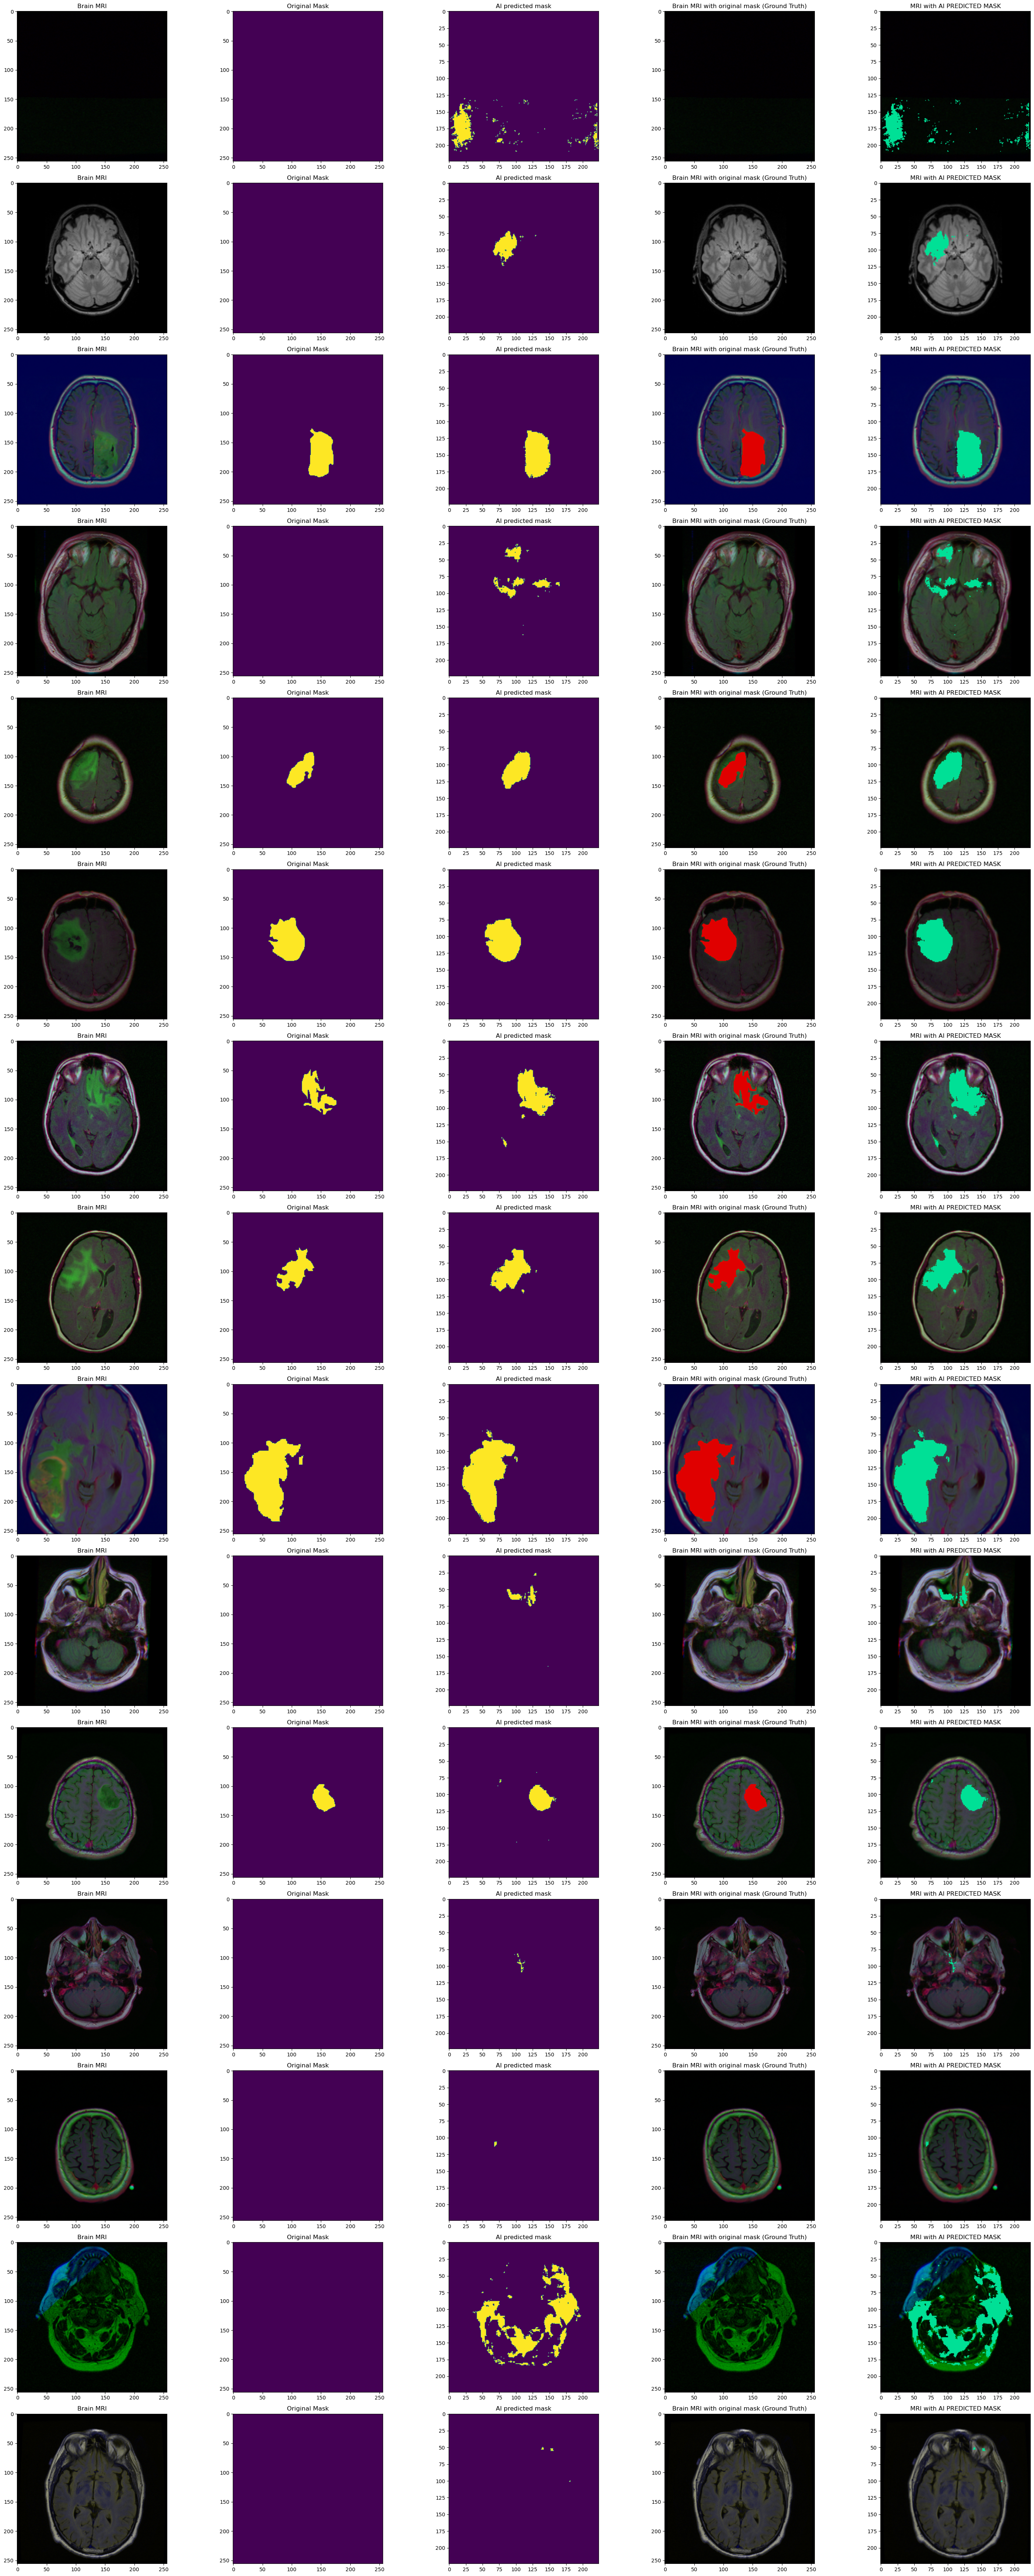

In [70]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (224,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_ =cv2.resize(img_,(224,224))
        img_[pred==1] = (0,224,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if  count==15:
        break

fig.tight_layout()        